##1. Implement BPE Algorithm (4 marks):

Develop a Python implementation of the Byte Pair Encoding (BPE) algorithm, covering key
steps such as learning byte pair merges and encoding/decoding using the learned merge
operations.

In [ ]:
from typing import List, Dict
import re
import heapq
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import defaultdict

class BPE():
    def __init__(self, debug=False ):
        self.vocab = defaultdict(lambda:0)
        self.corpus = defaultdict(lambda:0)
        self.debug = debug


    def init_corpus_vocab(self, raw_data: str):
        """
        Corpus is a dict of word in list of chars to frequency
        Vocab is a dict of tokens to frequency
        """
        corpus = defaultdict(lambda: 0)
        vocab = defaultdict(lambda:0)

        words = raw_data.split()

        for word in words:
            corpus[' '.join(list(word)) + ' _'] += 1
            for token in word+"_":
                vocab[token]+=1

        return corpus,vocab

    # def isStopChar(self,token:str)->bool:
    #     return bool(re.match('[,.?"\'!;:]+',token))

    def get_pairs(self, corpus: Dict[str, int])->heapq:
        pairs = defaultdict(lambda: 0)

        for word, freq in corpus.items():
            tokens = word.split()

            # Pair to frequency, avoiding stop characters
            for i in range(len(tokens) - 1):
              #  if not (self.isStopChar(tokens[i]) or self.isStopChar(tokens[i+1])):
                  pairs[tokens[i], tokens[i + 1]] += freq

        pairs = [(-freq, pair) for pair, freq in pairs.items()]
        heapq.heapify(pairs)

        return pairs

    def merge_corpus(self, pair, corpus):
        """
        merge pair appears in the corpus
        """

        bigram = ' '.join(pair)
        merged_pair = ''.join(pair)

        #find pairs allowing spaces for before or at the end
        for word in list(corpus.keys()):

            if bigram in word:
                new_word = word.replace(bigram, merged_pair)
                corpus[new_word] = corpus.pop(word)

        return corpus


    def update_vocab(self, pair, freq,vocab):
        """
        Save merged pair, and reduce the pair frequency in vocab
        """
        vocab[''.join(pair)] = freq

        for token in pair:
            if vocab[token] - freq == 0:
                del vocab[token]
            else:
                vocab[token] -=freq

        return


    def byte_pair_encoding(self, data:str, k:int):
        """
        From the given raw data strings, merge most frequent adjacent pairs till k times,
        returns vocab, a set of learnt vocab from corpus
        """
        corpus,vocab = self.init_corpus_vocab(data)

        self.vocab_size = []
        self.merge_info =[]


        for i in tqdm(range(k), desc="BPE Training", unit="merge"):
            pairs_heap = self.get_pairs(corpus)

            #most frequent pair
            freq_neg, best = heapq.heappop(pairs_heap)

            if not best:
                break

            self.update_vocab(best, -freq_neg, vocab)

            corpus = self.merge_corpus(best, corpus)

            self.vocab_size.append(len(vocab))
            self.merge_info.append(-freq_neg)

            if self.debug:
                print(f"\n--After {i} iteration")
                print("Most freq pairs: ", best)
                print("Corpus after update: ", corpus)



        self.corpus = corpus
        self.vocab = sorted(vocab,key=lambda k : len(k),reverse=True)

        return self.vocab, corpus


    def encoding(self, raw_data: str)-> List[str]:
        """
        Replace substring using the learned tokens in vocab
        """

        def replace_substring_with_tokens_to_list(word, sorted_tokens):
            # Sort tokens by length in descending order to match longer tokens first

            result = []
            i = 0

            while i < len(word):
                matched = False

                # Check each token
                for token in sorted_tokens:
                    # If the token is found in the word at the current position
                    if word[i:i+len(token)] == token:
                        result.append(token)  # Add token to the result
                        i += len(token)       # Skip the length of the token in the word
                        matched = True
                        break

                # If no token matched, move to the next character and treat as unknown
                if not matched:
                    result.append("[unknown]")  # Add unknown token
                    i += 1

            return result



        if not self.vocab:
            print("Vocab not learned. Ending...")
            return;

        encoded = []

        words = [word + '_' for word in raw_data.split()]

        #sorted tokens from the longest to the shortest
        sorted_vocab = sorted(self.vocab, key=lambda k: len(k), reverse=True)

        for word in tqdm(words, desc="Encoding words", unit="word"):
            encoded.extend(replace_substring_with_tokens_to_list(word, sorted_vocab))

        return encoded;


    def decoding(self, encoded:List[str])->List[str]:
        end_symb = '_'

        decoded = encoded

        #merge tokens if not seperate by end symbol
        for i in range(len(decoded)-1):
            if decoded[i][-1] != end_symb:
                merged = decoded[i] + decoded[i+1]
                decoded[i] = merged
                del decoded[i+1]

        return decoded




## 2.Train on NLTK Dataset (3 marks):
Utilize NLTK's Gutenberg Corpus, selecting books like "austen-emma.txt," "blake-poems.txt"
and "shakespeare-hamlet.txt" for training the BPE algorithm. Create a vocabulary based on
the training.

In [ ]:
### Download

import nltk
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
from nltk.corpus import gutenberg

In [ ]:

book_list = gutenberg.fileids()

print("Available Books:")
for book in book_list:
  print(book)

Available Books:
austen-emma.txt
austen-persuasion.txt
austen-sense.txt
bible-kjv.txt
blake-poems.txt
bryant-stories.txt
burgess-busterbrown.txt
carroll-alice.txt
chesterton-ball.txt
chesterton-brown.txt
chesterton-thursday.txt
edgeworth-parents.txt
melville-moby_dick.txt
milton-paradise.txt
shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt
whitman-leaves.txt


# Training Vocab learned from selected Books

In [ ]:
selected_books = [
    gutenberg.raw('austen-emma.txt'),
    gutenberg.raw('blake-poems.txt'),
    gutenberg.raw('shakespeare-hamlet.txt')
]
training_dataset = " ".join(selected_books)

# add book to corpus
bpe = BPE(debug=False)
#trainning
vocab, corpus = bpe.byte_pair_encoding(training_dataset, 6000)
list(vocab)[:10]

# print("\nVocab: ",vocab)
# print("Corpus: ",corpus)

BPE Training: 100%|██████████| 6000/6000 [06:08<00:00, 16.30merge/s]


['Comicall-Historicall-Pastorall:_',
 'recommendations_',
 'disappointment_',
 'circumstances,_',
 'Guildensterne._',
 'barouche-landau',
 'encouragement,_',
 'recommendation_',
 'consciousness,_',
 'court-plaister_']

In [ ]:
sorted_vocab = sorted(vocab,key = lambda k: len(k), reverse=True)
sorted_vocab[:5]

['disappointment_',
 'circumstances,_',
 'Guildensterne._',
 'barouche-landau',
 'circumstances_']

#3. Test on NLTK dataset(3marks)


In [ ]:
from urllib.request import urlopen

#Download Frankenstein txt
frankenstein_text_url = "http://www.gutenberg.org/files/41445/41445-0.txt"
frankenstein_text_raw = urlopen(frankenstein_text_url).read().decode('utf8')

dracula_text_url = "https://www.gutenberg.org/cache/epub/345/pg345.txt"
dracula_text_raw = urlopen(dracula_text_url).read().decode('utf8')

sherlock_text_url = "https://www.gutenberg.org/cache/epub/1661/pg1661.txt"
sherlock_text_raw = urlopen(sherlock_text_url).read().decode('utf8')


frankenstein_text_raw[0:300]

'\ufeffThe Project Gutenberg eBook of Frankenstein, by Mary Shelley\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gut'

## Tokenize on test dataset

In [ ]:
# Tokenization
model = bpe
encoding_tokens = bpe.encoding(frankenstein_text_raw)

#tokenization preview
encoding_tokens[:10]


Encoding words: 100%|██████████| 75773/75773 [02:55<00:00, 431.12word/s]


['[unknown]', 'The_', 'Pro', 'je', 'ct_', 'Gu', 'ten', 'ber', 'g_', 'e']

In [ ]:
cleaned_tokens = [dirty_token.rstrip('_') for dirty_token in encoding_tokens]

## 4.Create Reference Tokenization (2 marks):

In [ ]:
from nltk.tokenize import word_tokenize

test_dataset = frankenstein_text_raw
reference_tokens = word_tokenize(test_dataset)
reference_tokens[:20]


['\ufeffThe',
 'Project',
 'Gutenberg',
 'eBook',
 'of',
 'Frankenstein',
 ',',
 'by',
 'Mary',
 'Shelley',
 'This',
 'eBook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'in']

## 5. Compare with Standard Tokenization (2 marks):

## Tokenization Accuracy

In [ ]:
# Compare tokenization

print("BPE tokenization length: ",len(cleaned_tokens))
print("NLTK reference tokenize length: ", len(reference_tokens))

BPE tokenization length:  121227
NLTK reference tokenize length:  87753


In [ ]:
#measure tokenization accuracy, coverage, Precision, Recall, F1-Score
# tokenization accuracy
from collections import Counter

#Accuracy
def calc_tokenization_accuracy(predict: List[str],reference:List[str])->float:
    """
    tokenization accuracy = true count / total reference

    """

    reference_counter = Counter(reference)
    true_cnt = 0

    for token in predict:
        if reference_counter[token] > 0:
            true_cnt += 1
            reference_counter[token] -= 1

    print(f"Correctly Tokenized Tokens: {true_cnt}")
    print(f"Total reference Tokens: {len(reference)}")

    return true_cnt / len(reference)

accuracy_float = calc_tokenization_accuracy(cleaned_tokens, reference_tokens)
print(f"\nAccuracy: {accuracy_float * 100} %")


Correctly Tokenized Tokens: 56046
Total reference Tokens: 87753

Accuracy: 63.867901952070014 %


## Tokenization Coverage

In [ ]:
#Coverage
def calc_tokenization_coverage(predict:List[str],reference:List[str])->float:
    """
    Coverage = Unique Tokens Covered/Unique Tokens in the Ground Truth
    """

    predict_set = set(predict)

    reference_set = set(reference)

    true_cnt = 0

    for token in predict_set:
        if token in reference_set:
            true_cnt+=1

    coverage = true_cnt/len(reference_set)

    print("Unique covered tokens: ",true_cnt)
    print("Unique Tokens in Ground Truth: ", len(reference_set))

    return coverage

coverage_float = calc_tokenization_coverage(cleaned_tokens,reference_tokens)
print(f"Coverage: {coverage_float * 100} %")


Unique covered tokens:  1679
Unique Tokens in Ground Truth:  7901
Coverage: 21.250474623465383 %


In [ ]:
#Precision
def calc_precision(predict:List[str], reference: List[str])->float:
    """
    Precision = True positive / (True positive + False Positive)
    """

    reference_counter = Counter(reference)
    true_pos = 0
    false_pos = 0

    for token in predict:
        if reference_counter[token]>0:
            true_pos+=1
            reference_counter[token]-=1
        else:
            false_pos +=1

    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    return precision

precision_float = calc_precision(cleaned_tokens,reference_tokens)
print(f"Precision: {precision_float * 100} %")


Precision: 46.232274988245194 %


In [ ]:
#recall

def calc_recall(predict:List[str],reference: List[str])->float:
    """
    Recall = True pos / (True pos + False Neg)

    """

    reference_counter = Counter(reference)
    predict_counter = Counter(predict)

    false_neg = 0
    true_pos =0

    #True pos
    for token in predict:
        if reference_counter[token]>0:
            true_pos+=1
            reference_counter[token]-=1

    #False neg
    for token, ref_count in reference_counter.items():
        if ref_count > predict_counter[token]:
            false_neg += ref_count - predict_counter[token]

    return true_pos/(true_pos + false_neg)

recall_float = calc_recall(cleaned_tokens,reference_tokens)
print(f"Recall: {recall_float * 100} %")


Recall: 68.37045892600094 %


In [ ]:
#F1 score
def calc_F1_score(precision:float, recall:float)->float:
    return 2*precision*recall/(precision+recall)

f1_score = calc_F1_score(precision_float,recall_float)

print(f"Precision: {f1_score * 100} %")


Precision: 55.16311435475218 %


In [ ]:
# Jaccard Similarity
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    """
    The Jaccard Similarity coefficient is a statistic used for
    gauging the similarity and diversity of sample sets.
    It measures similarity between finite sets
    and is defined as the size of the intersection divided by
    the size of the union of the sample sets.

    """
    set1 = set(list1)
    set2 = set(list2)

    # Calculate intersection and union
    intersection = set1.intersection(set2)
    union = set1.union(set2)

    # Compute Jaccard Similarity
    if not union:
        return 0.0  # Avoid division by zero
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

similarity = jaccard_similarity(cleaned_tokens,reference_tokens)
print(f"Jaccard Similarity: {similarity * 100} %")


Jaccard Similarity: 16.602392959557005 %


## 6 Visualizations(2 marks):


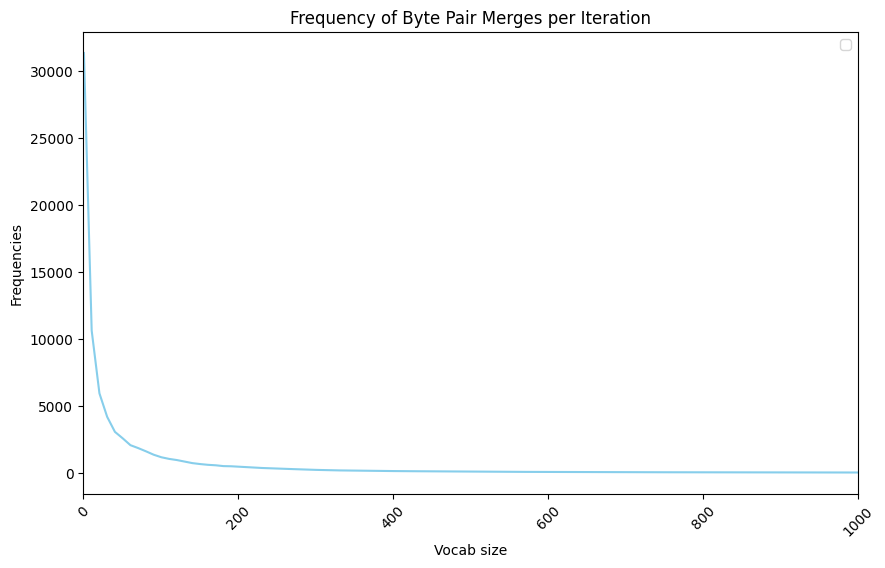

In [ ]:
import matplotlib.pyplot as plt

def visualize_pair_merge_freq(vocab_size:List[int], merge_info:List[int])->None:
        """
        visualize growth of vocab size to merge frequencies
        """

        frequencies_y = merge_info
        vocab_size_x = [i for i, _ in enumerate(vocab_size, start=1)]


        plt.figure(figsize=(10, 6))
        plt.plot(vocab_size_x[::10], frequencies_y[::10], color='skyblue')
        plt.xlabel('Vocab size')
        plt.ylabel('Frequencies')
        plt.title('Frequency of Byte Pair Merges per Iteration')
        plt.xticks(rotation=45)
        plt.legend()
        plt.xlim(0,1000)
        plt.show()


#Visualize x - vocab size, y - merge freq
visualize_pair_merge_freq(model.vocab_size, model.merge_info)